레이블링한 레시피 데이터를 모델에 학습시킬 수 있는 데이터로 전처리하는 코드이다. 설명을 따라 순서대로 실행시켜보자.

**1. 구글 드라이브를 코랩에 연결한다.**
> 이는 추후 모델을 불러오고, 전처리할 데이터를 불러오기 위해 필요한 과정이다. \
 따라서 이 코드를 실행하기 전에, 구글 드라이브에 모델과 토크나이저, 전처리할 데이터를 업로드 해야 한다.





In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!pip install transformers
!pip install tqdm
!pip install keras
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 27.1 MB/s 
     |████████████████████████████████| 7.6 MB 56.6 MB/s 
     |████████████████████████████████| 182 kB 80.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm, tqdm_notebook
from keras import optimizers
from transformers import AdamW
from transformers import ElectraForTokenClassification, ElectraTokenizerFast
import torch
import numpy as np
from transformers import BertForTokenClassification
import pandas as pd

**2. 파인튜닝한 최종 모델과 토크나이저를 불러온다.**
> "/content/gdrive/MyDrive/2022_lesik_workspace/lesik/model/MODEL_NEW_CORPUS_PLUS_NO_ACT_STATE_EPOCH_72"는 드라이브 내의 경로를 나타내는데, 왼쪽의 폴더 버튼을 눌러서 원하는 데이터의 경로를 확인할 수 있다. 아래 사진을 참고하자.



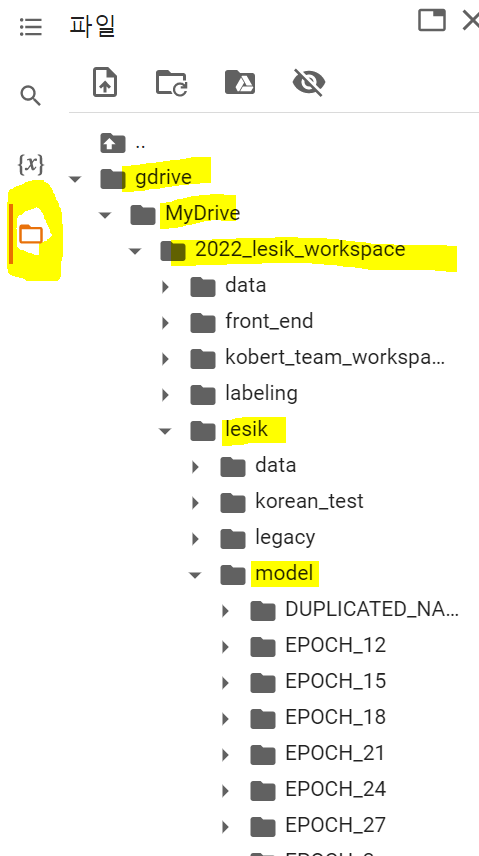

In [4]:
# model = ElectraForTokenClassification.from_pretrained("/content/gdrive/MyDrive/2022_lesik_workspace/lesik/model/DUPLICATED_NA_YS_EPOCH_72")
# tokenizer = ElectraTokenizerFast.from_pretrained("/content/gdrive/MyDrive/2022_lesik_workspace/lesik/tokenizer/DUPLICATED_NA_YS_EPOCH_72")
model = ElectraForTokenClassification.from_pretrained("/content/gdrive/MyDrive/2022_lesik_workspace/lesik/model/MODEL_NEW_CORPUS_PLUS_NO_ACT_STATE_EPOCH_72")
tokenizer = ElectraTokenizerFast.from_pretrained("/content/gdrive/MyDrive/2022_lesik_workspace/lesik/tokenizer/TOKENIZER_NEW_CORPUS_PLUS_NO_ACT_STATE_EPOCH_72")

**3. 레이블링된 레시피 데이터를 전처리하여 학습할 수 있는 데이터로 만든다**
> dir_path는 전처리할 레시피들이 들어있는 폴더 경로이다.\
f는 전처리가 완료된 데이터가 저장될 경로이다.\
taaag에는 레이블링한 태그 목록이다. 레이블링한 데이터에 사용된 태그를 적으면 된다.




In [5]:
import os
def preprocess():
  dir_path = '/content/gdrive/MyDrive/2022_lesik_workspace/lesik/data/recipe/no_pool_test/real_final'
  f = open('/content/gdrive/MyDrive/2022_lesik_workspace/lesik/data/total_test.tsv', 'w')
  f.write("text" + "\t" + "label" + "\n")

  taaag = ['CV_INGREDIENT', 'CV_SEASONING', 'QT_TEMPERATURE', 'CV_ACT', 'CV_STATE', 'QT_VOLUME', 'TI_DURATION']

  for path in os.listdir(dir_path):
      if os.path.isfile(os.path.join(dir_path, path)):
          print("======================" + path + "======================")
          file = open(os.path.join(dir_path, path), 'r') # 레시피 파일 읽기
          recipe = file.read() # 통으로 읽기
          file.close()
          recipe = recipe.strip() # 레시피 앞뒤 공백 제거
          sliced_recipe = recipe.split("\n") # 조리 방법 구분
          sliced_recipe = list(filter(None, sliced_recipe))

          for step in sliced_recipe:
              tag_list = [] #태그를 저장하는 리스트 [토큰, 태그]
              #태그 추출
              while(True):
                  tag_start = step.find("<")
                  if tag_start == -1:
                      break
                  tag_end = step.find(">")
                  tag_content = step[tag_start+1:tag_end].split(":") # 재료, 태그 구분
                  if tag_content[1] not in taaag:
                    return [path, step, tag_content]
                  tag_tok = tokenizer.tokenize(tag_content[0])
                  print(tag_tok)
                  for i in tag_tok:
                      tag_list.append([i, tag_content[1]])
                  step = step[:tag_start] + tag_content[0] + step[tag_end+1:] # 태그 제거한 문장 제작
              print(step)
              print(tokenizer.tokenize(step))

              first_step = step[0]
              if '0' <= step[0] <= '9': step = '*' + step[1:] # 순서가 time, volume의 숫자로 인식돼서 태깅이 잘못된 문제를 해결하기 위함
              tokenized_sentence = tokenizer.tokenize(step)
              label_list = ["O" for i in range(len(tokenized_sentence))] # 토큰 길이만큼 O로 구성된 리스트 제작

              # 토큰화
              error = False
              for token, tag in tag_list:
                  #print("token", token)
                  try:
                      token_idx = tokenized_sentence.index(token)
                      error = False
                  except ValueError:
                      token_ele_idx = 0
                      for token_ele in tokenized_sentence:
                          #print(token_ele)
                          #print(token)
                          if token_ele.find(token) != -1: #토큰이 존재 
                              #print(token)
                              if tag == "[UNK]":
                                  continue
                              else:
                                  label_list[token_ele_idx] = tag
                              tokenized_sentence[token_ele_idx] = "O" # 찾은 토큰을 또 검색하는 것을 방지하기 위함
                              error = True
                              break
                          token_ele_idx += 1
                  if error is not True:
                      label_list[token_idx] = tag
                      tokenized_sentence[token_idx] = "O"
              if(len(tokenized_sentence) != len(label_list)):
                  print( path + " 실패")
              print(label_list)
              print("------------------------------------------------------")

              step = first_step + step[1:]
              # 데이터 작성
              f.write(step + "\t" + " ".join(label_list) + "\n")
  f.close()
  
  return

그림 아래의 코드를 실행시키면 전처리한 파일명, 인식된 개체명, 원문, 원문 토큰화, 토큰별 레이블링 정보가 아래의 그림과 같이 출력된다.\
출력된 정보를 보고, 어느 지점에서 어떤 에러가 났는지 파악할 수 있다.

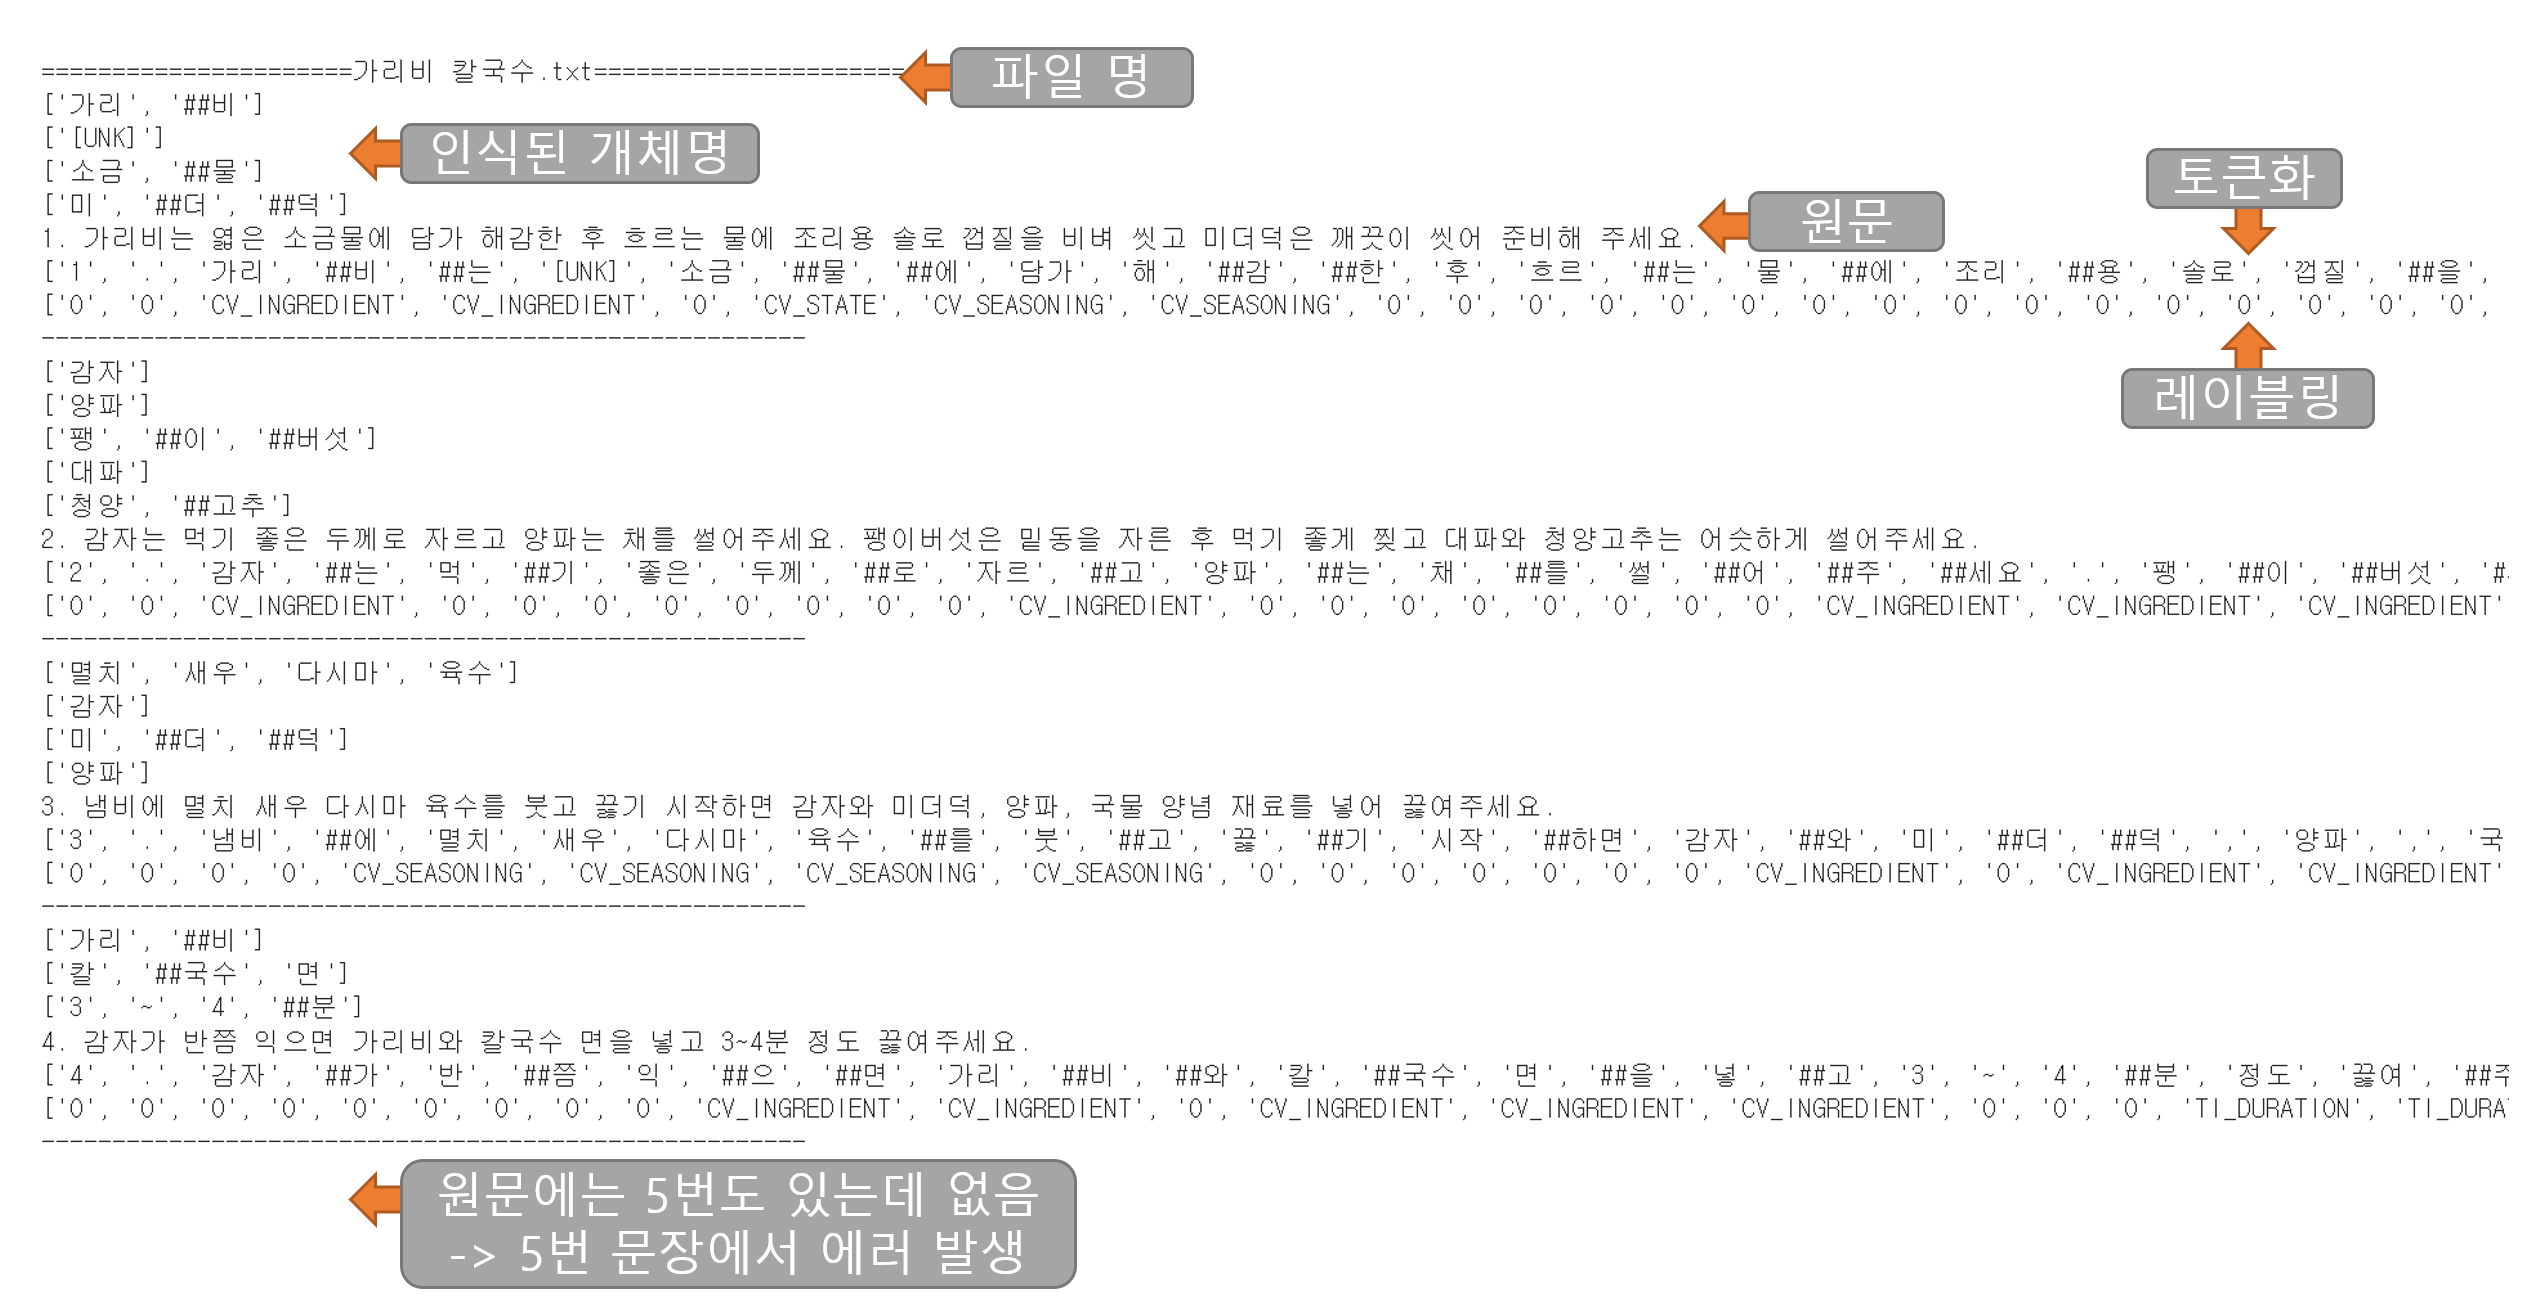

In [6]:
error = preprocess()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
['생수']
['섞']
['담']
['3', '##시간']
['얼', '##려']
1. 열무김치 국물과 생수를 섞은 후 지퍼백에 담아 살얼음이 생기도록 3시간 정도 미리 얼려주세요.
['1', '.', '열', '##무', '##김치', '국물', '##과', '생수', '##를', '섞', '##은', '후', '지퍼', '##백', '##에', '담', '##아', '살', '##얼', '##음', '##이', '생기', '##도록', '3', '##시간', '정도', '미리', '얼', '##려', '##주', '##세요', '.']
['O', 'O', 'CV_SEASONING', 'CV_SEASONING', 'CV_SEASONING', 'CV_SEASONING', 'O', 'CV_SEASONING', 'O', 'CV_ACT', 'O', 'O', 'O', 'O', 'O', 'CV_ACT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'TI_DURATION', 'TI_DURATION', 'O', 'O', 'CV_ACT', 'CV_ACT', 'O', 'O', 'O']
------------------------------------------------------
['소금']
['넣']
['마늘', '##종']
['10', '##초']
['데', '##친']
['헹', '##구']
['빼']
2. 끓는 물에 소금을 넣고 마늘종을 10초 정도 데친 후 찬물에 헹구어 물기를 빼주세요.
['2', '.', '끓', '##는', '물', '##에', '소금', '##을', '넣', '##고', '마늘', '##종', '##을', '10', '##초', '정도', '데', '##친', '후', '찬물', '##에', '헹', '##구', '##어', '물기', '##를', '빼', '##주', '##세요', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'CV_SEA

**4. 에러를 파악한다.**


> 아래 코드를 실행하면, 에러가 발생한 파일 명과, 에러 발생 문장, 에러 발생 태그 정보가 출력된다.\
taaag에 존재하지 않는 태그가 있을 때, 에러 발생 지점을 파악할 수 있다.

출력 예시
> ['가리비 칼국수.txt', '5. 마지막에 <대파:INGREDIENT>, <팽이버섯:CV_INGREDIENT>, <청양고추:CV_INGREDIENT>를 넣고 <굵은:CV_STATE> <천일염:CV_SEASONING>으로 간을 가감한 후 한소끔 끓인 후 불을 꺼주세요.', ['대파', 'INGREDIENT']]

-> 가리비 칼국수.txt 파일의 5번째 문장에서 대파가 CV_INGREDINET가 아니라 INGREDIENT로 태깅되어 문제가 발생한 경우이다.


In [7]:
print(error)

None
